# Transform NorESM data to DGGS

## Context

### Purpose

The goal is to experiment with how to transform NorESM data into DGGS (healpix grid).

```{warning}
This FAIR2Adapt case study will likely require different types of interpolation, as bilinear interpolation is not suitable for all variables. For instance, conservative interpolation is currently being developed.
```

### Description

In this notebook, we will:
- Open online NorESM data 
- Transform one variable (TREFHT) into DGGS Healpix
- Save the transformed data in Zarr

## Contributions

### Notebook


- Even Moa Myklebust, Simula Research Laboratory (Norway) (author), @evenmm
- Anne Fouilloux, Simula Research Laboratory (Norway) (reviewer), @annefou
- Ola Formo Kihle, Independent Consultant / UW Contractor (Norway) (reviewer), @ofk123

## Bibliography and other interesting resources

- [The Norwegian Earth System Model (NorESM)](https://noresm-docs.readthedocs.io/en/latest/)
- NorESM dataset used in this notebook, [10.11582/2024.00093](https://doi.org/10.11582/2024.00093)

## Import Libraries

In [1]:
# Install xarray-healpy and dggs libraries for regridding
#!pip install git+https://github.com/IAOCEA/xarray-healpy.git git+https://github.com/xarray-contrib/xdggs.git cmcrameri

In [2]:
import os
import numpy as np
import s3fs                                                # For accessing file storage at Amazon S3
import xdggs                                               # Discrete global grid systems in x-array
import xarray as xr                                        # N-dimensional arrays with dimension, coordinate and attribute labels
from xarray_healpy import HealpyGridInfo, HealpyRegridder
xr.set_options(display_expand_data=False, display_expand_attrs=False, keep_attrs=True)

## Open file with Xarray
- The file is on the cloud (accessible to everyone)
- The first time, opening the atmosphere ds typically takes a few minutes
- Therefore, we save a local version with selected subset of variables for faster loading the nezxt times

In [3]:
# Define file paths
subset_dataset_path = "small_N1850_f19_tn14_20190722.cam.h0.1801-01.zarr"
endpoint_url = 'https://pangeo-eosc-minioapi.vm.fedcloud.eu/'
filename_atmosphere = "s3://afouilloux-fair2adapt/10.11582_2024.00093/N1850_f19_tn14_20190722/atm/hist/N1850_f19_tn14_20190722.cam.h0.1801-01.nc"

# Check if the small dataset exists
if os.path.exists(subset_dataset_path):
    print(f"Loading local subset dataset from {subset_dataset_path}")
    ds = xr.open_zarr(subset_dataset_path)
else:
    # Extract file from S3
    print(f"Local subset of variables not found. Loading full dataset from {endpoint_url}")
    client_kwargs={'endpoint_url': endpoint_url}
    s3 = s3fs.S3FileSystem(anon=True, client_kwargs=client_kwargs)
    
    # Opening the atmosphere ds typically takes a few minutes
    atmosphere_ds = xr.open_dataset(s3.open(filename_atmosphere))

    # Save a subset for faster access on reload
    print("Saving subset of variables to subset_dataset")
    atmosphere_ds[["SST", "TREFHT"]].to_zarr(subset_dataset_path)
    ds = xr.open_zarr(subset_dataset_path)

# Display the subset dataset
ds

Loading local subset dataset from small_N1850_f19_tn14_20190722.cam.h0.1801-01.zarr


<xarray.Dataset> Size: 113kB
Dimensions:  (time: 1, lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 8B 1801-02-01 00:00:00
Data variables:
    SST      (time, lat, lon) float32 55kB dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    TREFHT   (time, lat, lon) float32 55kB dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
Attributes: (9)

## Quick visualization of reference height temperature (TREFHT)

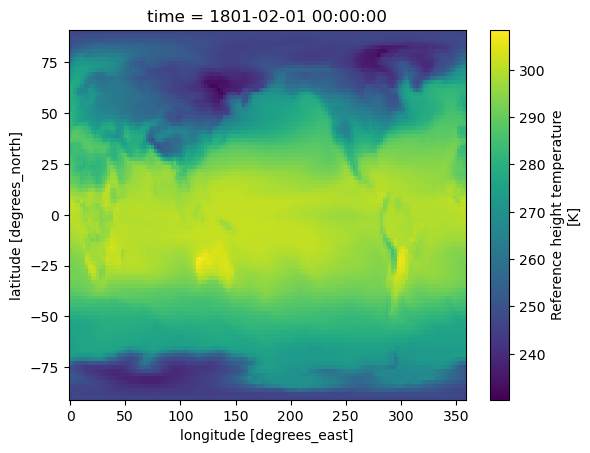

In [4]:
# Plot reference height temperature (TREFHT)
ds.TREFHT.isel(time=0).plot()

## Standardize coordinate names and center longitude

In [5]:
ds = ds.rename_dims({"lat": "latitude", "lon": "longitude"})
ds = ds.rename_vars({"lat": "latitude", "lon": "longitude"})
ds.latitude.attrs["standard_name"] = 'latitude'
ds.longitude.attrs["standard_name"] = 'longitude'

<br>Center around 0 longitude:

In [6]:
ds.coords['longitude'] = (ds.coords['longitude'] + 180) % 360 - 180
ds = ds.sortby(ds.longitude)

## Regridding 
### Define the target grid (Healpix DGGS)

In [7]:
def center_longitude(ds, center):
    if center == 0:
        centered = (ds.longitude + 180) % 360 - 180
    else:
        centered = (ds.longitude - 180) % 360 + 180
    return ds.assign_coords(longitude=centered)

In [8]:
nside = 16                               # Each side of the original 12 faces in Healpix is divided into nside parts 
healpy_grid_level = int(np.log2(nside))  # Healpix level
number_of_cells = 12*nside**2            # The resulting total number of cells

print("nside:", nside)
print("Level:", healpy_grid_level)
print("Number of cells:", number_of_cells)

nside: 16
Level: 4
Number of cells: 3072


In [9]:
# Define the target Healpix grid
grid = HealpyGridInfo(level=healpy_grid_level)
target_grid = grid.target_grid(ds).pipe(center_longitude, 0).drop_attrs(deep=False).dggs.decode({"grid_name": "healpix", "nside": nside, "indexing_scheme": "nested"})

In [10]:
%%time
# Compute interpolation weights for regridding diff data
regridder = HealpyRegridder(
    ds[["longitude", "latitude"]].compute(),
    target_grid,
    method="bilinear",
    interpolation_kwargs={},
)
print(regridder)

HealpyRegridder(method='bilinear', interpolation_kwargs={})
CPU times: user 3.59 s, sys: 228 ms, total: 3.82 s
Wall time: 3.83 s


In [11]:
%%time
regridded = regridder.regrid_ds(ds).pipe(xdggs.decode)

CPU times: user 1.38 s, sys: 616 ms, total: 1.99 s
Wall time: 2.01 s


In [12]:
%%time
ds_regridded = regridded.TREFHT.compute().squeeze()

CPU times: user 186 ms, sys: 12.1 ms, total: 198 ms
Wall time: 196 ms


In [13]:
ds_regridded.dggs.explore()

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x78132bd5…

# Save the transformed data to zarr

In [14]:
url = f"./NorESM-TREFHT-healpix-lvl-{healpy_grid_level}.zarr"
print("url:", url)
ds_regridded.to_zarr(url,mode='w')

url: ./NorESM-TREFHT-healpix-lvl-4.zarr
